In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'interspecies_development'
os.environ["DJ_SCHEMA_NAME"] = f"konstantin_nnsysident_{name}"

In [3]:
import re
import torch
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 25)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders, static_loaders, static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

from dataport.bcm.static import PreprocessedMouseData

<ipython-input-3-2985c291158e>:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Iterable


Connecting konstantin@134.2.168.16:3306


---

In [4]:
experiment_names = ['Transfer between areas']

# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame(((TrainedModelTransfer *
                           ExperimentsTransfer.Restrictions &
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Transfer * Seed ).fetch()) #* OracleScoreTransfer
    data = pd.concat([data, data_])

# # Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['dataset_comment', 'transfer_comment'])
# data = data.loc[data['seed'] == 1]

# # Get labels
data["target data"] = data.apply(lambda row: row['dataset_comment'].split("Transfer dataset: ")[1].split(" neurons (218)")[0] , axis=1)
data["origin data (used for core)"] = data.apply(lambda row: row['transfer_comment'].split(" core from")[0] , axis=1)

data = data.pivot(index="origin data (used for core)", columns='target data', values='score')
data = (data/data.max()*100).round(1)
data = np.exp(data)

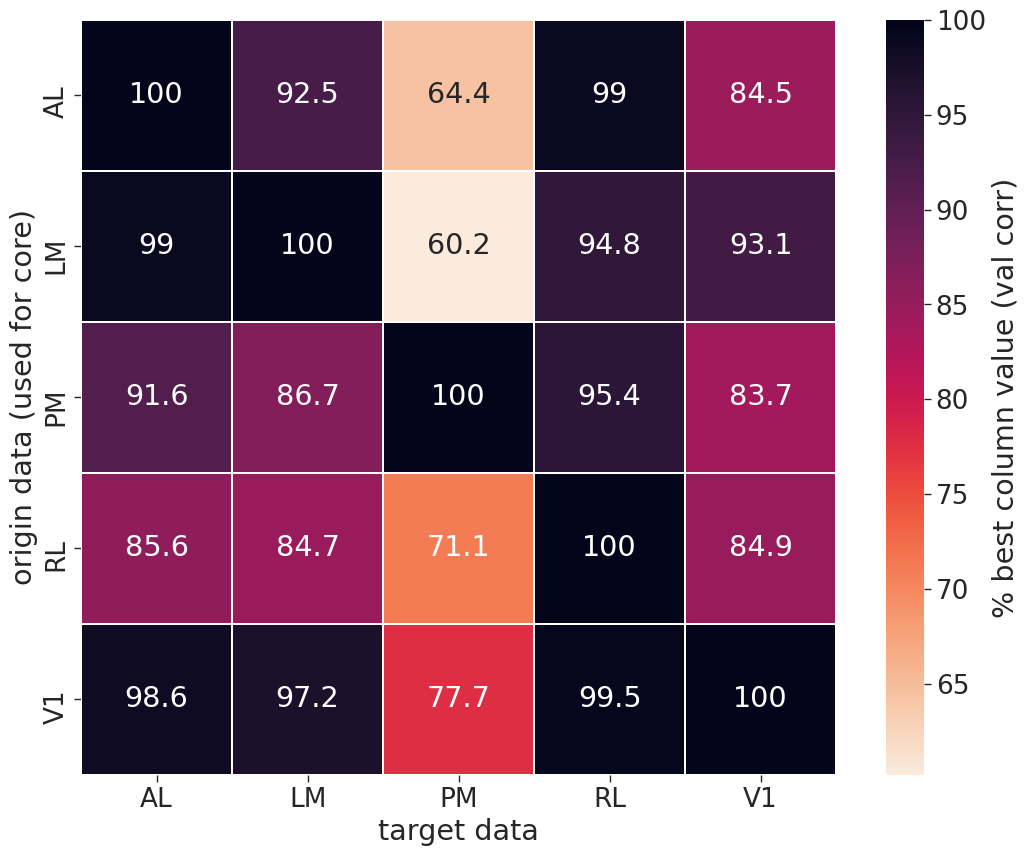

In [27]:
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):

    fig, axes = plt.subplots(figsize=(13, 10), dpi=100)
    sns.heatmap(data, annot=True, fmt="g", cmap='rocket_r', ax=axes, linewidths=.5, square=True, cbar_kws={'label': '% best column value (val corr)'})
    fig.savefig('inter_area.png', bbox_inches='tight')

___